困惑度 3.3, 26506.8 标记/秒 cuda:0


ValueError: not enough values to unpack (expected 2, got 1)

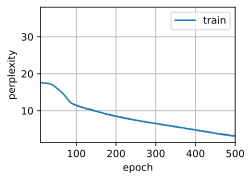

In [2]:
import math
import torch
from torch import nn
from torch.nn import functional as f 
from d2l import torch as d2l


class LSTMModelScratch:
    def __init__(self, batch_size, vocab_size, num_hiddens, device_name):
        self.vocab_size = vocab_size 
        self.num_hiddens = num_hiddens
        self.device = device_name
        self.params  = self.params(vocab_size, num_hiddens, self.device)

    def __call__(self, inputs, state):
         inputs = f.one_hot(inputs.T, self.vocab_size).type(torch.float32)
         inputs = inputs.to(self.device)
         W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o,  W_xc, W_hc, b_c, W_hq, b_q = self.params
         H, C, = state
         outputs = []
         for X in inputs:
            I = torch.sigmoid(torch.mm(X, W_xi) + torch.mm(H, W_hi) + b_i)
            F = torch.sigmoid(torch.mm(X, W_xf) + torch.mm(H, W_hf) + b_f)
            O = torch.sigmoid(torch.mm(X, W_xo) + torch.mm(H, W_ho) + b_o)

            C_delta = torch.tanh(torch.mm(X, W_xc) + torch.mm(H, W_hc) + b_c)
            C = F * C + I * C_delta
            H = torch.tanh(C) * O
            Y = torch.mm(H,W_hq) + b_q
            outputs.append(Y)
         return torch.cat(outputs, dim=0), (H,C,)


    def normal(self, shape, device):
        return torch.randn(size=shape, device=device) * 0.01

    def three(self, num_inputs, num_hiddens, device):
        return torch.rand((num_inputs,num_hiddens), device=device) * 0.01,\
               torch.rand((num_hiddens,num_hiddens), device=device) * 0.01, \
               torch.zeros(num_hiddens, device=device)


    def params(self, vocab_size, num_hiddens, device):
        num_inputs = num_outputs = vocab_size

        W_xi, W_hi, b_i = self.three(num_inputs, num_hiddens, device)
        W_xf, W_hf, b_f = self.three(num_inputs, num_hiddens, device)
        W_xo, W_ho, b_o = self.three(num_inputs, num_hiddens, device)
        W_xc, W_hc, b_c = self.three(num_inputs, num_hiddens, device)

        W_hq = self.normal((num_hiddens, num_outputs), device)
        b_q  = torch.zeros(num_outputs, device=device)

        params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o,  W_xc, W_hc, b_c, W_hq, b_q]
        for param in params:
            param.requires_grad_(True)
        return params 

def begin_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),torch.zeros((batch_size, num_hiddens), device=device), )





def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


def predict_next_char(net, prefix, num_preds, num_hiddens, vocab, device):

    state = begin_state(1, num_hiddens, device)
    outputs = [vocab[prefix[0]]]
    get_next =  lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))

    for y in prefix[1:]:
        _, state = net(get_next(), state)
        outputs.append(vocab[y])
    
    for i in range(num_preds):
        y, state  = net(get_next(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    return ''.join([vocab.idx_to_token[i] for i in outputs])



def train_one_step(net, state, train_iter, loss, updater, lr, device):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        for s in state:
            s.detach()
        y = Y.T.reshape(-1).to(device)
        l = loss(net(X, state)[0], y).mean()
        l.backward() 
        grad_clipping(net, 1)
        updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0]/ metric[1]), metric[1] / timer.stop()


def train_rnn(net, state,  train_iter, loss, updater, lr, device, epoch):
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, epoch])
    predict = lambda prefix: predict_next_char(net, prefix, 50, num_hiddens, vocab, device)
    for epoch in range(epoch):
        ppl, speed = train_one_step(net, state, train_iter, loss, updater, lr, device)
        # print(predict('time traveller'))
        animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


batch_size = 32
num_steps =  35
num_hiddens = 512
lr = 1 
epoch = 500

train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
test_rnn = LSTMModelScratch(batch_size, len(vocab), num_hiddens, d2l.try_gpu())
loss = nn.CrossEntropyLoss()
updater = lambda batch_size: d2l.sgd(test_rnn.params, lr, batch_size)
state = begin_state(batch_size, num_hiddens, d2l.try_gpu())

train_rnn(test_rnn, state, train_iter, loss, updater, lr, d2l.try_gpu(), epoch)
